In [1]:
import os
import random
import itertools

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO
from ipywidgets import interact, FloatSlider

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

# 特徴量選択
from sklearn.feature_selection import (
    SequentialFeatureSelector,
    VarianceThreshold,
    RFE,
    RFECV,
)
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# 機械学習モデル
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析

# 学習中
from tqdm import tqdm
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings

# config python file
import config

SEED = config.SEED


from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

/Users/masanari/Library/CloudStorage/OneDrive-東京理科大学/projects/breast_cancer_analytics/notebooks/functions.py:242: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


In [2]:
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


# 特徴量チェック
def check(df):
    col_list = df.columns.values  # 列名を取得
    row = []
    for col in col_list:
        unique = ""
        value_counts = ""
        if df[col].nunique() < 12:
            unique = df[col].unique()
            value_counts = df[col].value_counts().to_dict()
        tmp = (
            col,  # 列名
            df[col].dtypes,  # データタイプ
            df[col].isnull().sum(),  # null数
            df[col].count(),  # データ数 (欠損値除く)
            df[col].nunique(),  # ユニーク値の数 (欠損値除く)
            unique,  # ユニーク値
            value_counts,  # ユニーク値のそれぞれの個数
        )
        row.append(tmp)  # tmpを順次rowに保存
    df = pd.DataFrame(row)  # rowをデータフレームの形式に変換
    df.columns = [
        "feature",
        "dtypes",
        "nan",
        "count",
        "num_unique",
        "unique",
        "unique_counts",
    ]  # データフレームの列名指定
    # unique_countsの中身確認のために横幅拡張
    d = dict(selector=".col8", props=[("min-width", "200px")])  # name
    # display(df.style.set_table_styles([d]))
    # display(df)
    return df.style.set_table_styles([d])

# データ読み込み

In [3]:
df_patient = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_patient.txt", header=4
)
df_sample = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_sample.txt", header=4
)

In [4]:
df_patient.shape, df_sample.shape

((2509, 24), (2509, 13))

In [5]:
df_clinical = pd.merge(df_patient, df_sample, on="PATIENT_ID")
check(df_clinical)

,feature,dtypes,nan,count,num_unique,unique,unique_counts
0,PATIENT_ID,object,0,2509,2509,,
1,LYMPH_NODES_EXAMINED_POSITIVE,float64,266,2243,32,,
2,NPI,float64,222,2287,436,,
3,CELLULARITY,object,592,1917,3,[nan 'High' 'Moderate' 'Low'],"{'High': 965, 'Moderate': 737, 'Low': 215}"
4,CHEMOTHERAPY,object,529,1980,2,['NO' 'YES' nan],"{'NO': 1568, 'YES': 412}"
5,COHORT,float64,11,2498,9,[ 1. 2. 3. 5. 4. 9. 7. 6. nan 8.],"{1.0: 809, 3.0: 763, 2.0: 288, 4.0: 238, 5.0: 170, 7.0: 105, 8.0: 82, 9.0: 40, 6.0: 3}"
6,ER_IHC,object,83,2426,2,['Positve' 'Negative' nan],"{'Positve': 1817, 'Negative': 609}"
7,HER2_SNP6,object,529,1980,4,['NEUTRAL' 'LOSS' nan 'GAIN' 'UNDEF'],"{'NEUTRAL': 1436, 'GAIN': 438, 'LOSS': 101, 'UNDEF': 5}"
8,HORMONE_THERAPY,object,529,1980,2,['YES' 'NO' nan],"{'YES': 1216, 'NO': 764}"
9,INFERRED_MENOPAUSAL_STATE,object,529,1980,2,['Post' 'Pre' nan],"{'Post': 1556, 'Pre': 424}"


## カラムの順序変更（読みやすさのため）

In [6]:
def align_columns(df: pd.DataFrame, regex: str):
    # まとめたいcolumnの正規表現を一時退避
    df_copy = df.copy()
    df_tmp = df_copy.filter(regex=regex)
    # 元のdfから落とす
    df_copy.drop(df_tmp.columns, axis=1, inplace=True)
    # 元のdfに結合
    return pd.merge(df_copy, df_tmp, right_index=True, left_index=True)

In [7]:
df_clinical.filter(regex="^ER|^HER2")

,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS
0,Positve,NEUTRAL,Positive,Negative
1,Positve,NEUTRAL,Positive,Negative
2,Positve,NEUTRAL,Positive,Negative
3,Positve,NEUTRAL,Positive,Negative
4,Positve,NEUTRAL,Positive,Negative
...,...,...,...,...
2504,Positve,NaN,Positive,NaN
2505,Positve,NaN,Positive,NaN
2506,NaN,NaN,NaN,NaN
2507,NaN,NaN,NaN,NaN


In [8]:
# 癌の種類
df_clinical = align_columns(df_clinical, "^CANCER_")
# 重要そう（直感）な特徴量
df_clinical = align_columns(df_clinical, "^ER_|^HER2_|^TUMOR_")
# 治療の種類
df_clinical = align_columns(df_clinical, ".*_THERAPY$|^BREAST_SURGERY")
# target系の種類（OS, RFS, VITAL）
df_clinical = align_columns(df_clinical, "^OS_.*|^RFS_.*|^VITAL_.*")

check(df_clinical)

,feature,dtypes,nan,count,num_unique,unique,unique_counts
0,PATIENT_ID,object,0,2509,2509,,
1,LYMPH_NODES_EXAMINED_POSITIVE,float64,266,2243,32,,
2,NPI,float64,222,2287,436,,
3,CELLULARITY,object,592,1917,3,[nan 'High' 'Moderate' 'Low'],"{'High': 965, 'Moderate': 737, 'Low': 215}"
4,CHEMOTHERAPY,object,529,1980,2,['NO' 'YES' nan],"{'NO': 1568, 'YES': 412}"
5,COHORT,float64,11,2498,9,[ 1. 2. 3. 5. 4. 9. 7. 6. nan 8.],"{1.0: 809, 3.0: 763, 2.0: 288, 4.0: 238, 5.0: 170, 7.0: 105, 8.0: 82, 9.0: 40, 6.0: 3}"
6,INFERRED_MENOPAUSAL_STATE,object,529,1980,2,['Post' 'Pre' nan],"{'Post': 1556, 'Pre': 424}"
7,SEX,object,0,2509,1,['Female'],{'Female': 2509}
8,INTCLUST,object,529,1980,11,['4ER+' '3' '9' '7' '4ER-' nan '5' '8' '10' '1' '2' '6'],"{'8': 299, '3': 290, '4ER+': 260, '10': 226, '7': 190, '5': 190, '9': 146, '1': 139, '6': 85, '4ER-': 83, '2': 72}"
9,AGE_AT_DIAGNOSIS,float64,11,2498,1843,,


In [9]:
# 重複カラム確認
# df_clinical.T.duplicated()
# SAMPLE_IDのみ（PATIENT_IDと重複している）

In [10]:
# データの型の定義（適用する前処理が大きく異なるため）

int_columns = [
    # patient
    "LYMPH_NODES_EXAMINED_POSITIVE",
    "OS_MONTHS",
    "RFS_MONTHS",
]

float_columns = [
    # patient
    "NPI",
    "AGE_AT_DIAGNOSIS",
    # sample
    "TUMOR_SIZE",
    "TMB_NONSYNONYMOUS",
]

str_columns = []

# 質的変数（順序尺度）
num_cat_columns = [
    # patient
    "CELLULARITY",
    "ER_IHC",
    "HER2_SNP6",
    "INFERRED_MENOPAUSAL_STATE",
    # sample
    "ER_STATUS",
    "HER2_STATUS",
    "GRADE",
    "PR_STATUS",
    "TUMOR_STAGE",
]
# 質的変数（名義尺度）
str_cat_columns = [
    # patient
    "COHORT",
    "INTCLUST",
    "CLAUDIN_SUBTYPE",
    "THREEGENE",
    "HISTOLOGICAL_SUBTYPE",
    "BREAST_SURGERY",
    "LATERALITY",
    "VITAL_STATUS",
    # sample
    "CANCER_TYPE",
    "CANCER_TYPE_DETAILED",
    "ONCOTREE_CODE",
]

bool_columns = [
    # patient
    "CHEMOTHERAPY",
    "HORMONE_THERAPY",
    "RADIO_THERAPY",
    "OS_STATUS",
    "RFS_STATUS",
]

meanless_columns = [
    # patient
    "PATIENT_ID",
    "SEX",
    # sample
    #'PATIENT_ID',
    "SAMPLE_ID",
    "SAMPLE_TYPE",
]

print(
    df_clinical.shape[1],
    len(int_columns)
    + len(float_columns)
    + len(str_columns)
    + len(num_cat_columns)
    + len(str_cat_columns)
    + len(bool_columns)
    + len(meanless_columns),
)
assert df_clinical.shape[1] == len(int_columns) + len(float_columns) + len(
    str_columns
) + len(num_cat_columns) + len(str_cat_columns) + len(bool_columns) + len(
    meanless_columns
), "lack or too much columns"

36 36


In [11]:
# データを大きく2つに分割できるので、ここで分割
df_MB = df_clinical[df_clinical["PATIENT_ID"].str.contains("MB")]
df_MTST = df_clinical[df_clinical["PATIENT_ID"].str.contains("MTS-T")]
df_MB.shape, df_MTST.shape

((1985, 36), (524, 36))

In [12]:
# save
make_dir(config.INTERIM_PICKLE_EDA_DIR)
df_clinical.to_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_clinical.pkl")
df_MB.to_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MB.pkl")
df_MTST.to_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MTST.pkl")

# OS_MONTHSとRFS_MONTHSの確認

秋本先生によると、どちらも「診察結果、乳がんと判明」したときからの時間らしい  
- OS_MONTHS：生存期間▷乳がんと診察されてからの生存期間?  
- RFS_MONTHS：再発期間▷乳がんと診断されてからの再発までの期間（完治後からではなく最初の診断時から？違和感がある・・・）？

これらを確認していく

<AxesSubplot:ylabel='OS_MONTHS'>

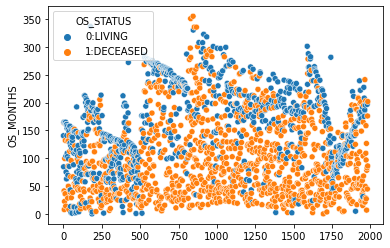

In [13]:
sns.scatterplot(x=df_MB.index, y=df_MB.OS_MONTHS, hue=df_MB.OS_STATUS)

<AxesSubplot:ylabel='RFS_MONTHS'>

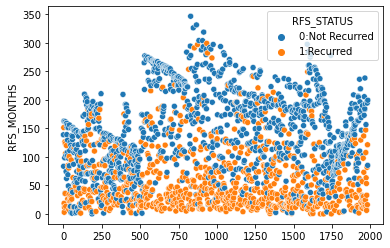

In [14]:
sns.scatterplot(x=df_MB.index, y=df_MB.RFS_MONTHS, hue=df_MB.RFS_STATUS)

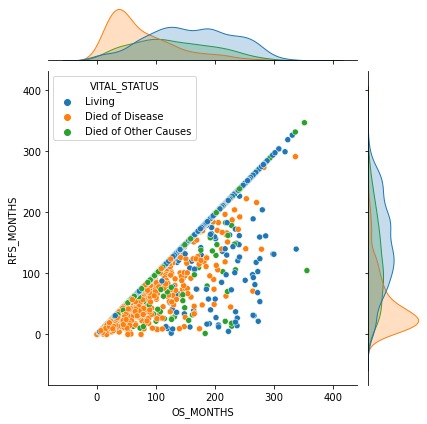

In [15]:
sns.jointplot(x="OS_MONTHS", y="RFS_MONTHS", data=df_MB, hue=df_MB.VITAL_STATUS)
plt.show()

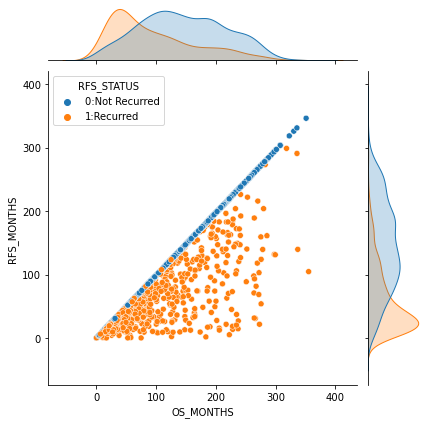

In [16]:
# OS_MONTHSとRFS_MONTHSのサイズの確認
# 定義通りであれば、OS_MONTHS>=RFS_MONTHSであることが可視化される
sns.jointplot(x="OS_MONTHS", y="RFS_MONTHS", data=df_MB, hue=df_MB.RFS_STATUS)
plt.show()

In [17]:
print(len(df_MB))  # サンプル数
# 定義に反したデータがないかの確認
print((df_MB.OS_MONTHS < df_MB.RFS_MONTHS).sum())  # OS_MONTHS<RFS_MONTHSとなるサンプル数
print((df_MB.OS_MONTHS == df_MB.RFS_MONTHS).sum())  # OS_MONTHS==RFS_MONTHSとなるサンプル数

1985
0
2


OS_MONTHS >= RFS_MONTHSであるため、秋本先生から伺った定義は正しいと考えて良さそう

In [18]:
df_MB[(df_MB.OS_MONTHS == df_MB.RFS_MONTHS)][
    ["PATIENT_ID", "OS_MONTHS", "RFS_MONTHS", "VITAL_STATUS", "RFS_STATUS"]
]

,PATIENT_ID,OS_MONTHS,RFS_MONTHS,VITAL_STATUS,RFS_STATUS
186,MB-0284,0.0,0.0,Living,0:Not Recurred
1694,MB-6229,0.1,0.1,Died of Disease,1:Recurred


この2件はなんなのだろうか？  
特にMB-6229が再発期間も短く不明である

# 治療間の目的変数の違い

In [19]:
# 学習でも使用するデータセット（train, testも同じ）
X = pd.read_pickle(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X.pkl")
y = pd.read_pickle(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/y.pkl")


# 説明変数のdf
X_train = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X_train.pkl"
)
X_test = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/X_test.pkl"
)

# 目的変数のpd.Series
y_train = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/y_train.pkl"
)
y_test = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_CLINICAL_DIR + "/y_test.pkl"
)

In [20]:
check(X_train)

,feature,dtypes,nan,count,num_unique,unique,unique_counts
0,LYMPH_NODES_EXAMINED_POSITIVE,float64,0,1187,30,,
1,NPI,float64,0,1187,232,,
2,CELLULARITY,int64,0,1187,3,[3 2 1],"{3: 629, 2: 437, 1: 121}"
3,CHEMOTHERAPY,int64,0,1187,2,[0 1],"{0: 926, 1: 261}"
4,INFERRED_MENOPAUSAL_STATE,int64,0,1187,2,[1 0],"{1: 921, 0: 266}"
5,AGE_AT_DIAGNOSIS,float64,0,1187,1044,,
6,GRADE,int64,0,1187,3,[2 3 1],"{3: 599, 2: 492, 1: 96}"
7,PR_STATUS,int64,0,1187,2,[0 1],"{1: 625, 0: 562}"
8,TMB_NONSYNONYMOUS,float64,0,1187,28,,
9,ER_IHC,int64,0,1187,2,[1 0],"{1: 915, 0: 272}"


In [21]:
check(df_MB)

,feature,dtypes,nan,count,num_unique,unique,unique_counts
0,PATIENT_ID,object,0,1985,1985,,
1,LYMPH_NODES_EXAMINED_POSITIVE,float64,76,1909,31,,
2,NPI,float64,1,1984,323,,
3,CELLULARITY,object,68,1917,3,[nan 'High' 'Moderate' 'Low'],"{'High': 965, 'Moderate': 737, 'Low': 215}"
4,CHEMOTHERAPY,object,5,1980,2,['NO' 'YES' nan],"{'NO': 1568, 'YES': 412}"
5,COHORT,float64,0,1985,5,[1. 2. 3. 5. 4.],"{3.0: 763, 1.0: 526, 2.0: 288, 4.0: 238, 5.0: 170}"
6,INFERRED_MENOPAUSAL_STATE,object,5,1980,2,['Post' 'Pre' nan],"{'Post': 1556, 'Pre': 424}"
7,SEX,object,0,1985,1,['Female'],{'Female': 1985}
8,INTCLUST,object,5,1980,11,['4ER+' '3' '9' '7' '4ER-' nan '5' '8' '10' '1' '2' '6'],"{'8': 299, '3': 290, '4ER+': 260, '10': 226, '7': 190, '5': 190, '9': 146, '1': 139, '6': 85, '4ER-': 83, '2': 72}"
9,AGE_AT_DIAGNOSIS,float64,0,1985,1624,,


In [22]:
print(df_MB["HORMONE_THERAPY"].unique())
print(df_MB["RADIO_THERAPY"].unique())
print(df_MB["BREAST_SURGERY"].unique())

['YES' 'NO' nan]
['YES' 'NO' nan]
['MASTECTOMY' 'BREAST CONSERVING' nan]


In [23]:
print(len(df_MB[df_MB["HORMONE_THERAPY"].isnull()]))
print(len(df_MB[df_MB["RADIO_THERAPY"].isnull()]))
print(len(df_MB[df_MB["BREAST_SURGERY"].isnull()]))

5
5
30


In [24]:
"""
display(df_MB[df_MB["HORMONE_THERAPY"].isnull()])
display(df_MB[df_MB["RADIO_THERAPY"].isnull()])
display(df_MB[df_MB["BREAST_SURGERY"].isnull()])
"""

'\ndisplay(df_MB[df_MB["HORMONE_THERAPY"].isnull()])\ndisplay(df_MB[df_MB["RADIO_THERAPY"].isnull()])\ndisplay(df_MB[df_MB["BREAST_SURGERY"].isnull()])\n'

以下のindexについては欠損値が多すぎるため、削除したほうが良さそう
- 9
- 221
- 226
- 441
- 1680

BREAST_SURGERYがnullのデータは30件▷欠損と解釈して良さそう（手術していない、などではない）？

## 治療法ごとの患者のデータの観察

### 生存期間（OS）と再発期間（RFS）の同時表示

In [112]:
def EDA_treatment_RFS(df: pd.DataFrame()):
    print("sample size: ", len(df))
    print(
        "Died of Disease sample percentage: ",
        round(
            len(df[df["VITAL_STATUS"] == "Died of Disease"]) / len(df), 3
        ),  # 死亡者の割合（丸め誤差下3桁）
    )
    print(
        "RFS sample percentage: ",
        round(
            len(df[df["RFS_STATUS"] == "1:Recurred"]) / len(df), 3
        ),  # 再発者の占める割合（丸め誤差下3桁）
    )
    print("平均OS_MONTHS: ", round(df_tmp["OS_MONTHS"].mean(), 3))
    print("平均RFS_MONTHS: ", round(df_tmp["RFS_MONTHS"].mean(), 3))
    print(
        "OS_MONTHS - RFS_MONTHS < 1 size: ",
        len(df_tmp[df["OS_MONTHS"] - df["RFS_MONTHS"] < 1]),
    )
    print(
        "OS_MONTHS - RFS_MONTHS < 1 percentage: ",
        round(
            len(df[df["OS_MONTHS"] - df["RFS_MONTHS"] < 1])
            / len(df[df["RFS_STATUS"] == "1:Recurred"]),
            3,
        ),  # 全体に対する比率（丸め誤差下3桁）
    )
    plot = sns.jointplot(
        x="OS_MONTHS",
        y="RFS_MONTHS",
        data=df,
        hue="RFS_STATUS",
        hue_order=["0:Not Recurred", "1:Recurred"],
        xlim=(0, 400),
        ylim=(0, 400),
    )
    plt.show()

{'HORMONE_THERAPY': 'YES', 'RADIO_THERAPY': 'YES', 'BREAST_SURGERY': 'MASTECTOMY'}
sample size:  250
Died of Disease sample percentage:  0.508
RFS sample percentage:  0.592
平均OS_MONTHS:  108.083
平均RFS_MONTHS:  90.893
OS_MONTHS - RFS_MONTHS < 1 size:  27
OS_MONTHS - RFS_MONTHS < 1 percentage:  0.182


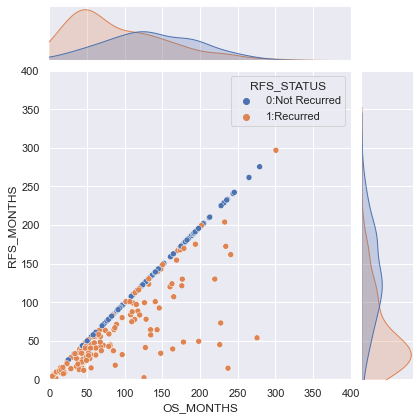

{'HORMONE_THERAPY': 'YES', 'RADIO_THERAPY': 'YES', 'BREAST_SURGERY': 'BREAST CONSERVING'}
sample size:  337
Died of Disease sample percentage:  0.347
RFS sample percentage:  0.412
平均OS_MONTHS:  126.059
平均RFS_MONTHS:  112.498
OS_MONTHS - RFS_MONTHS < 1 size:  37
OS_MONTHS - RFS_MONTHS < 1 percentage:  0.266


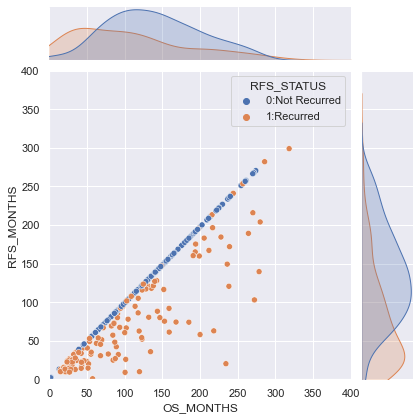

{'HORMONE_THERAPY': 'YES', 'RADIO_THERAPY': 'NO', 'BREAST_SURGERY': 'MASTECTOMY'}
sample size:  262
Died of Disease sample percentage:  0.5
RFS sample percentage:  0.527
平均OS_MONTHS:  118.42
平均RFS_MONTHS:  103.552
OS_MONTHS - RFS_MONTHS < 1 size:  31
OS_MONTHS - RFS_MONTHS < 1 percentage:  0.225


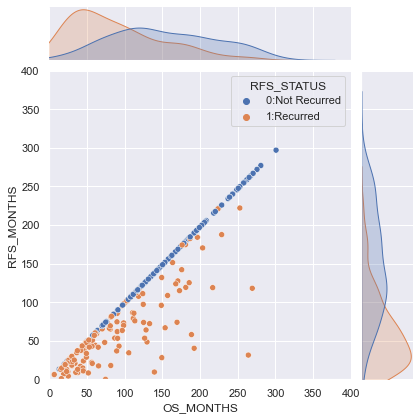

{'HORMONE_THERAPY': 'YES', 'RADIO_THERAPY': 'NO', 'BREAST_SURGERY': 'BREAST CONSERVING'}
sample size:  33
Died of Disease sample percentage:  0.333
RFS sample percentage:  0.394
平均OS_MONTHS:  111.81
平均RFS_MONTHS:  99.32
OS_MONTHS - RFS_MONTHS < 1 size:  7
OS_MONTHS - RFS_MONTHS < 1 percentage:  0.538


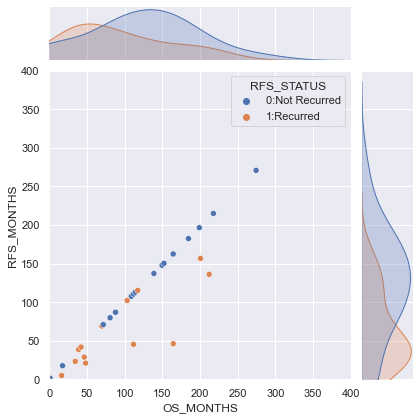

{'HORMONE_THERAPY': 'NO', 'RADIO_THERAPY': 'YES', 'BREAST_SURGERY': 'MASTECTOMY'}
sample size:  112
Died of Disease sample percentage:  0.643
RFS sample percentage:  0.652
平均OS_MONTHS:  92.439
平均RFS_MONTHS:  79.349
OS_MONTHS - RFS_MONTHS < 1 size:  13
OS_MONTHS - RFS_MONTHS < 1 percentage:  0.178


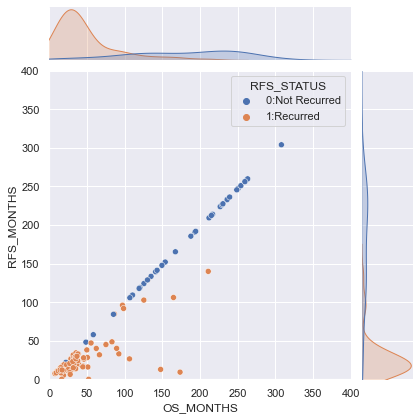

{'HORMONE_THERAPY': 'NO', 'RADIO_THERAPY': 'YES', 'BREAST_SURGERY': 'BREAST CONSERVING'}
sample size:  229
Died of Disease sample percentage:  0.306
RFS sample percentage:  0.397
平均OS_MONTHS:  151.103
平均RFS_MONTHS:  131.08
OS_MONTHS - RFS_MONTHS < 1 size:  11
OS_MONTHS - RFS_MONTHS < 1 percentage:  0.121


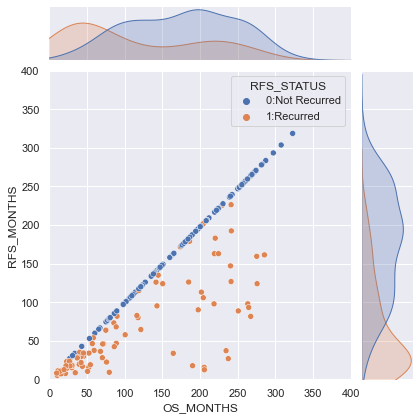

{'HORMONE_THERAPY': 'NO', 'RADIO_THERAPY': 'NO', 'BREAST_SURGERY': 'MASTECTOMY'}
sample size:  218
Died of Disease sample percentage:  0.463
RFS sample percentage:  0.528
平均OS_MONTHS:  137.973
平均RFS_MONTHS:  115.932
OS_MONTHS - RFS_MONTHS < 1 size:  36
OS_MONTHS - RFS_MONTHS < 1 percentage:  0.313


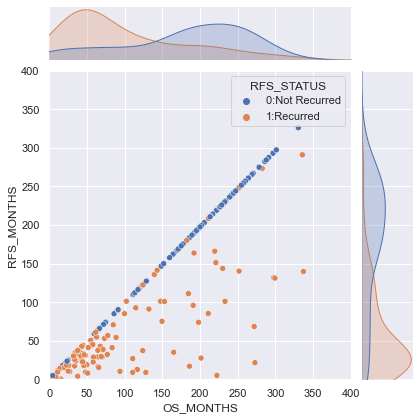

{'HORMONE_THERAPY': 'NO', 'RADIO_THERAPY': 'NO', 'BREAST_SURGERY': 'BREAST CONSERVING'}
sample size:  25
Died of Disease sample percentage:  0.32
RFS sample percentage:  0.48
平均OS_MONTHS:  137.487
平均RFS_MONTHS:  95.884
OS_MONTHS - RFS_MONTHS < 1 size:  2
OS_MONTHS - RFS_MONTHS < 1 percentage:  0.167


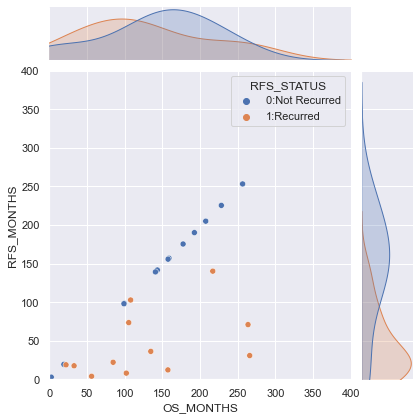

In [113]:
dic = {
    "HORMONE_THERAPY": ["YES", "NO"],
    "RADIO_THERAPY": ["YES", "NO"],
    "BREAST_SURGERY": ["MASTECTOMY", "BREAST CONSERVING"],
}

df_tmp = None  # 初期化
prod = [x for x in itertools.product(*dic.values())]
result = [dict(zip(dic.keys(), r)) for r in prod]


for n, r in enumerate(result):
    df_tmp = df_MB[
        (df_MB["HORMONE_THERAPY"] == r["HORMONE_THERAPY"])
        & (df_MB["RADIO_THERAPY"] == r["RADIO_THERAPY"])
        & (df_MB["BREAST_SURGERY"] == r["BREAST_SURGERY"])
    ]
    df_tmp = df_tmp[df_tmp["VITAL_STATUS"] != "Died of Other Causes"]
    print(r)
    EDA_treatment_RFS(df_tmp)
df_tmp = None  # 初期化

#### 考察

特異的な組み合わせ
- {'HORMONE_THERAPY': 'NO', 'RADIO_THERAPY': 'YES', 'BREAST_SURGERY': 'MASTECTOMY'}
再発している患者の割合が多い


In [118]:
def EDA_treatment_OS(df: pd.DataFrame()):
    print("sample size (Living, Died of Disease): ", len(df))
    print(
        "Died of Disease sample percentage: ",
        round(
            len(df[df["VITAL_STATUS"] == "Died of Disease"]) / len(df), 3
        ),  # 死亡者の割合（丸め誤差下3桁）
    )
    print(
        "RFS sample percentage: ",
        round(
            len(df[df["RFS_STATUS"] == "1:Recurred"]) / len(df), 3
        ),  # 再発者の占める割合（丸め誤差下3桁）
    )
    sns.set()
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(
        x="RFS_STATUS",
        y="OS_MONTHS",
        data=df,
        hue="VITAL_STATUS",
        hue_order=["Living", "Died of Disease"],
    )
    ax.set(ylim=(0, 400))
    plt.show()

{'HORMONE_THERAPY': 'YES', 'RADIO_THERAPY': 'YES', 'BREAST_SURGERY': 'MASTECTOMY'}
sample size (Living, Died of Disease):  250
Died of Disease sample percentage:  0.508
RFS sample percentage:  0.592


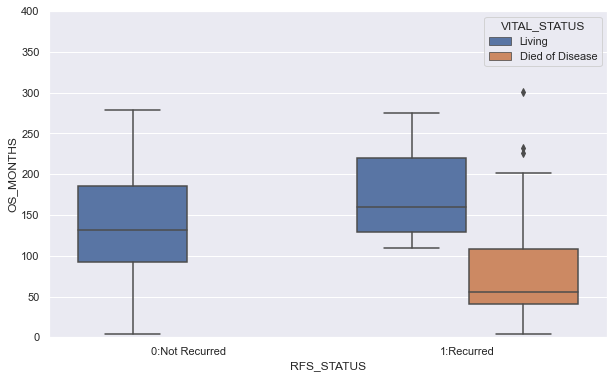

{'HORMONE_THERAPY': 'YES', 'RADIO_THERAPY': 'YES', 'BREAST_SURGERY': 'BREAST CONSERVING'}
sample size (Living, Died of Disease):  337
Died of Disease sample percentage:  0.347
RFS sample percentage:  0.412


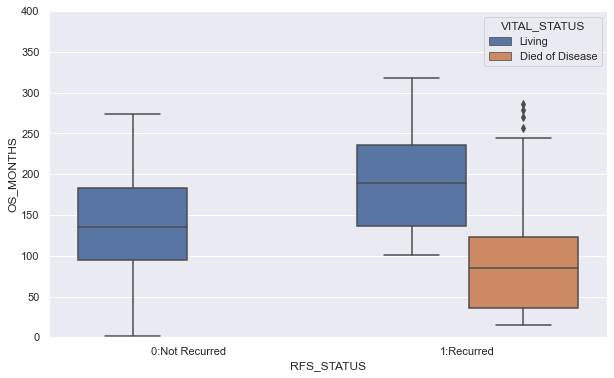

{'HORMONE_THERAPY': 'YES', 'RADIO_THERAPY': 'NO', 'BREAST_SURGERY': 'MASTECTOMY'}
sample size (Living, Died of Disease):  262
Died of Disease sample percentage:  0.5
RFS sample percentage:  0.527


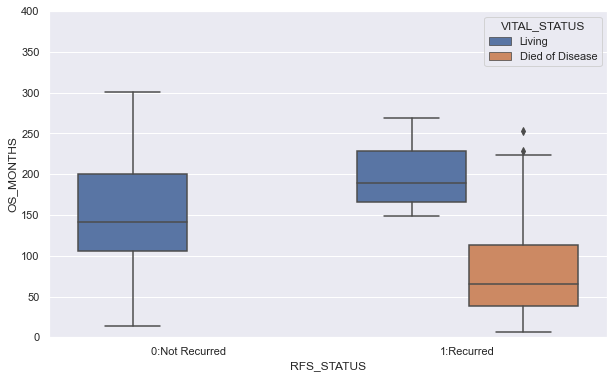

{'HORMONE_THERAPY': 'YES', 'RADIO_THERAPY': 'NO', 'BREAST_SURGERY': 'BREAST CONSERVING'}
sample size (Living, Died of Disease):  33
Died of Disease sample percentage:  0.333
RFS sample percentage:  0.394


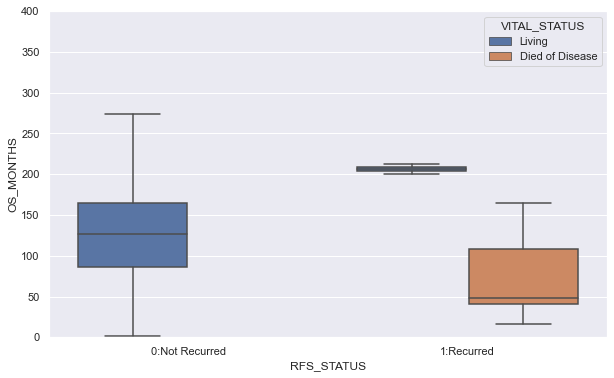

{'HORMONE_THERAPY': 'NO', 'RADIO_THERAPY': 'YES', 'BREAST_SURGERY': 'MASTECTOMY'}
sample size (Living, Died of Disease):  112
Died of Disease sample percentage:  0.643
RFS sample percentage:  0.652


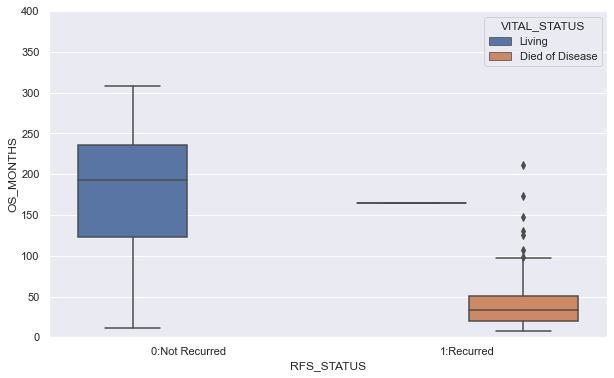

{'HORMONE_THERAPY': 'NO', 'RADIO_THERAPY': 'YES', 'BREAST_SURGERY': 'BREAST CONSERVING'}
sample size (Living, Died of Disease):  229
Died of Disease sample percentage:  0.306
RFS sample percentage:  0.397


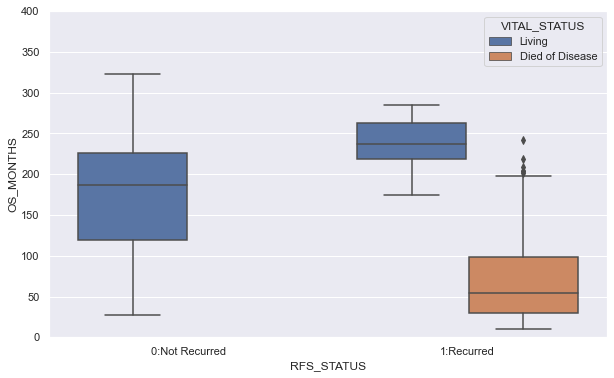

{'HORMONE_THERAPY': 'NO', 'RADIO_THERAPY': 'NO', 'BREAST_SURGERY': 'MASTECTOMY'}
sample size (Living, Died of Disease):  218
Died of Disease sample percentage:  0.463
RFS sample percentage:  0.528


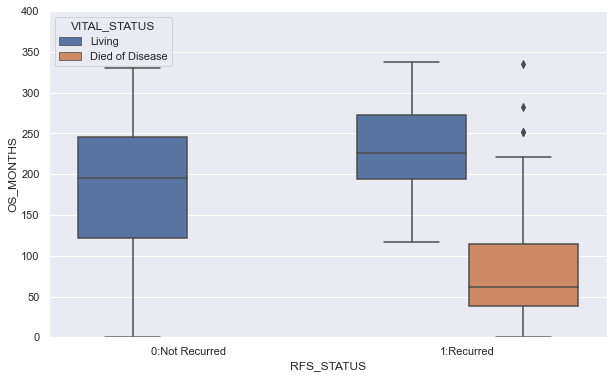

{'HORMONE_THERAPY': 'NO', 'RADIO_THERAPY': 'NO', 'BREAST_SURGERY': 'BREAST CONSERVING'}
sample size (Living, Died of Disease):  25
Died of Disease sample percentage:  0.32
RFS sample percentage:  0.48


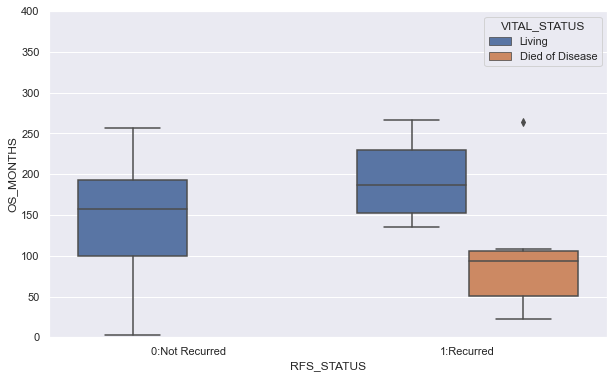

In [119]:
dic = {
    "HORMONE_THERAPY": ["YES", "NO"],
    "RADIO_THERAPY": ["YES", "NO"],
    "BREAST_SURGERY": ["MASTECTOMY", "BREAST CONSERVING"],
}


df_tmp = None  # 初期化
prod = [x for x in itertools.product(*dic.values())]
result = [dict(zip(dic.keys(), r)) for r in prod]
for r in result:
    df_tmp = df_MB[
        (df_MB["HORMONE_THERAPY"] == r["HORMONE_THERAPY"])
        & (df_MB["RADIO_THERAPY"] == r["RADIO_THERAPY"])
        & (df_MB["BREAST_SURGERY"] == r["BREAST_SURGERY"])
    ]
    df_tmp = df_tmp[df_tmp["VITAL_STATUS"] != "Died of Other Causes"]
    print(r)
    EDA_treatment_OS(df_tmp.sort_values("RFS_STATUS"))
df_tmp = None  # 初期化

# 生存曲線の観察

lifelinesというライブラリがあったので、試してみる。
https://lifelines.readthedocs.io/en/latest/index.html

In [30]:
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

In [31]:
# PATIENT_IDにMBを含むデータのみ含むデータフレームを読み込み
df_MB = pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MB.pkl")
df_MB.shape

(1985, 36)

<AxesSubplot:xlabel='timeline'>

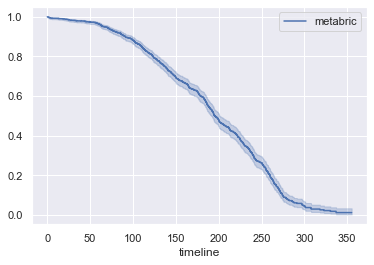

In [32]:
T = df_MB["OS_MONTHS"].dropna()
E = (
    df_MB["OS_STATUS"].dropna().map({"0:LIVING": 1, "1:DECEASED": 0})
)  # lifelinesを描くので、生存が1, 死亡が0

kmf = KaplanMeierFitter(label="metabric")
kmf.fit(T, E)
kmf.plot()